In [66]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
from scipy import signal
import numpy as np
import argparse
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import pims
import os
from scipy.signal import find_peaks
import peakutils

14733


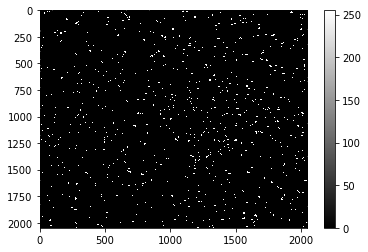

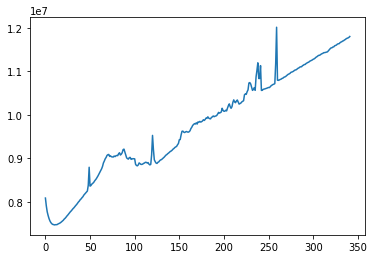

In [63]:
#Image Loading
str1 = 'images/'
date = '05_04_19'
name = '30uL_In_dots_spundown_retest_dish2_kgluc_added_frame_80_150ms'
other = '/jpgs/'# movie2_400ms
extension = '*.jpg'

path = str1+date+'/'+name+other+extension

if not os.path.exists('results/'+date+'/'+name+other):
    os.makedirs('results/'+date+'/'+name+other)

frames = pims.ImageSequence(path, as_grey=True)
total_frames = len(frames)

image= np.float64(frames[0])
for frameNum in range(1, total_frames-1):
    image = np.sum([image,np.int64(frames[frameNum])],axis=0)
    
image=image/image.max()
image = np.array(image * 255, dtype = np.uint8)

stacked_img = np.stack((image,)*3, axis=-1)
stacked_img_4 = np.stack((image,)*4, axis=-1)

gray = cv2.cvtColor(stacked_img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)
maxValue = 255

adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C#cv2.ADAPTIVE_THRESH_MEAN_C #cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thresholdType = cv2.THRESH_BINARY#cv2.THRESH_BINARY #cv2.THRESH_BINARY_INV

blockSize = 11 #odd number like 3,5,7,9,11
C = -2 # constant to be subtracted

#threshold for dye
#adaptivethreshold for dots
#ret3,im_thresholded = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im_thresholded = cv2.adaptiveThreshold(gray, maxValue, adaptiveMethod, thresholdType, blockSize, C)

labelarray, particle_count = ndimage.measurements.label(im_thresholded)

print particle_count

plt.figure(1)
plt.imshow(im_thresholded,cmap='gray', aspect='auto')
plt.colorbar()

frame_index = np.linspace(0,total_frames-1,total_frames,dtype='int')
frame_intensity = [0] * total_frames
overall_dict = dict(zip(frame_index, frame_intensity))

for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
    overall_dict[key1] = np.sum(im_thresholded*value1)
    
final_res = 'results/'+date+'/'+name+other+'z_dots.png'

fig = plt.figure()
ax = plt.axes()
ax.plot(overall_dict.keys(), overall_dict.values());
fig.savefig(final_res, bbox_inches='tight',dpi = 1000)

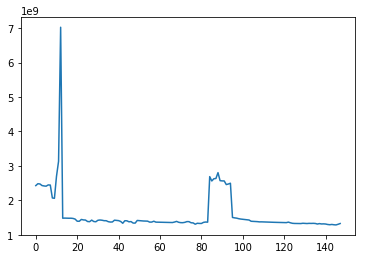

In [56]:
inv_dict = dict(zip(frame_index, frame_intensity))
for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
    inv_dict[key1] = np.sum((1-im_thresholded)*value1)
    
final_res = 'results/'+date+'/'+name+other+'z_everythingButDots.png'

fig = plt.figure()
ax = plt.axes()
ax.plot(inv_dict.keys(), inv_dict.values());
fig.savefig(final_res, bbox_inches='tight',dpi = 1000)

In [57]:
final_res = 'results/'+date+'/'+name+other+'z_dotsOverdots.png'
image = cv2.cvtColor(im_thresholded, cv2.COLOR_BGR2RGBA)
image[np.all(image == [0, 0, 0, 255], axis=2)] = [0, 0, 0, 0]
overlay = cv2.addWeighted(stacked_img_4, 1, image, 1, 0)
cv2.imwrite(final_res,overlay)

True

In [ ]:
#dye_values = np.array(overall_dict.values())

peaks, _ = find_peaks(dye_values, prominence=1)

plt.plot(peaks, dye_values[peaks], "ob"); 
plt.plot(dye_values); 
plt.legend(['prominence'])
plt.show()
peaks

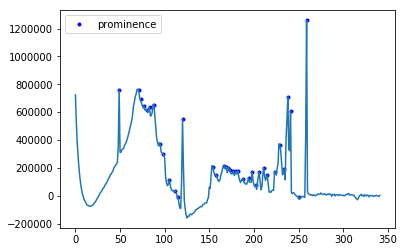

array([ 49,  71,  73,  77,  80,  83,  88,  95,  98, 105, 112, 115, 120,
       154, 158, 167, 169, 171, 173, 177, 180, 182, 188, 194, 198, 202,
       206, 211, 215, 224, 229, 234, 238, 241, 250, 259])

In [71]:
dot_values = np.array(overall_dict.values())

peaks, _ = find_peaks(dot_values, prominence=1)

dot_values_cut = np.subtract(dot_values,peakutils.baseline(dot_values))

plt.plot(peaks, dot_values_cut[peaks], ".b"); 
plt.plot(dot_values_cut); 
plt.legend(['prominence'])
plt.show()
peaks